In [1]:
import os
import tempfile
import time
from ansys.aedt.core import Hfss
import matplotlib.pyplot as plt
import numpy as np
#from Analise_CP import Z_par_g
#from Sintese_CP import synth_ant, synth_ant_pos
import pandas as pd
from scipy.optimize import minimize
from datetime import datetime
from scipy.odr import ODR, Model, RealData
import matplotlib.image as mpimg

AEDT_VERSION = "2024.2"
NUM_CORES = 4
NG_MODE = False
ConvP = 2

temp_folder = tempfile.TemporaryDirectory(suffix=".ansys")

project_name = os.path.join(temp_folder.name, "Spherical_Array.aedt")
design_name = "CP"
hfss = Hfss(version=AEDT_VERSION,
            non_graphical=NG_MODE,
            project=project_name,
            design = design_name,
            new_desktop=True,
            solution_type="Modal",
            )

PyAEDT INFO: Python version 3.11.6 (tags/v3.11.6:8b6ee5b, Oct  2 2023, 14:57:12) [MSC v.1935 64 bit (AMD64)].
PyAEDT INFO: PyAEDT version 0.16.1.
PyAEDT INFO: Initializing new Desktop session.
PyAEDT INFO: Log on console is enabled.
PyAEDT INFO: Log on file C:\Users\ITA\AppData\Local\Temp\pyaedt_ITA_df43d2b3-cee7-4850-803a-fd413d64befe.log is enabled.
PyAEDT INFO: Log on AEDT is disabled.
PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.
PyAEDT INFO: Launching PyAEDT with gRPC plugin.
PyAEDT INFO: New AEDT session is starting on gRPC port 56019.
PyAEDT INFO: Electronics Desktop started on gRPC port: 56019 after 10.243967056274414 seconds.
PyAEDT INFO: AEDT installation Path C:\Program Files\AnsysEM\v242\Win64
PyAEDT INFO: Ansoft.ElectronicsDesktop.2024.2 version started with process ID 14460.
PyAEDT INFO: Project Spherical_Array has been created.
PyAEDT INFO: Added design 'CP' of type HFSS.
PyAEDT INFO: Aedt Objects correctly read


In [2]:
# Variables
hfss["a"] = "100mm"
a = 0.1
hfss["numseg"] = "19"
hfss["h"] = "1.524mm"
h=0.001524

hfss["Dthetaa"] = "33.212deg"
hfss["Dphia"] = "44.485deg"
hfss["phip1"] = "90deg"
hfss["thetap1"] = "96.357deg"

hfss["Rteflon"] = "2.05mm"
Rteflon= 0.00205
hfss["rprobe"] = "0.65mm"
rprobe = 0.00065
hfss["Hprobe"] = "15.07mm"
Hprobe = 0.01507
orange = [255,128,64]
red = [255,0,0]
blue = [0,255,255]

Alphas = np.array([35,35,-35,-35])
Betas = np.array([25,-25,25,-25])
Gammas = np.array([0,0,0,0])

npoints = 31

PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec
PyAEDT INFO: Materials class has been initialized! Elapsed time: 0m 0sec
PyAEDT INFO: Parsing design objects. This operation can take time
PyAEDT INFO: Refreshing bodies from Object Info
PyAEDT INFO: Bodies Info Refreshed Elapsed time: 0m 0sec
PyAEDT INFO: 3D Modeler objects parsed. Elapsed time: 0m 0sec
PyAEDT INFO: Boundary Finite Conductivity Coating_Patch1 has been created.
PyAEDT INFO: Boundary Wave Port Wave_Port1 has been created.
PyAEDT INFO: Parsing design objects. This operation can take time
PyAEDT INFO: Refreshing bodies from Object Info
PyAEDT INFO: Bodies Info Refreshed Elapsed time: 0m 0sec
PyAEDT INFO: 3D Modeler objects parsed. Elapsed time: 0m 0sec
PyAEDT INFO: Boundary Finite Conductivity Coating_Patch2 has been created.
PyAEDT INFO: Boundary Wave Port Wave_Port2 has been created.
PyAEDT INFO: Parsing design objects. This operation can take time
PyAEDT INFO: Refreshing bodies from Object Info
PyAE

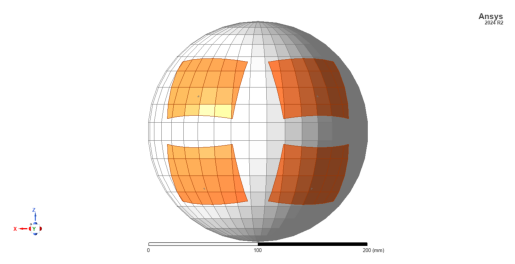

In [3]:
from pyaedt.modeler.cad.polylines import PolylineSegment

try:
    for i in range(4):
        hfss.modeler.coordinate_systems[0].delete()
    hfss.modeler.set_working_coordinate_system("Global")
except:
    pass
# Generate Geometry
start_point = ["0mm", "0mm", "a"]
center_point = ["0mm", "0mm", "0mm"]

Gnd_Sphere_Name = "Gnd_Sphere"
Gnd_Sphere = hfss.modeler.create_polyline(
    points=[start_point, start_point],
    segment_type=[PolylineSegment(
        segment_type="AngularArc",
        arc_center=center_point,
        arc_angle="-180deg",
        arc_plane="ZX",
        num_seg="numseg"
    ), PolylineSegment(
        segment_type="Line"
    )],
    name=Gnd_Sphere_Name
)

hfss.modeler.cover_lines(Gnd_Sphere_Name)

hfss.modeler.sweep_around_axis(Gnd_Sphere_Name, "360deg", number_of_segments="2*numseg")

Gnd_Sphere.material_name = "copper"
Gnd_Sphere.color = orange

start_point = ["0mm", "0mm", "a+h"]

Diel_Sphere_Name = "Diel_Sphere"
Diel_Sphere = hfss.modeler.create_polyline(
    points=[start_point, start_point],
    segment_type=[PolylineSegment(
        segment_type="AngularArc",
        arc_center=center_point,
        arc_angle="-180deg",
        arc_plane="ZX",
        num_seg="numseg"
    ), PolylineSegment(
        segment_type="Line"
    )],
    name=Diel_Sphere_Name
)

hfss.modeler.cover_lines(Diel_Sphere_Name)

hfss.modeler.sweep_around_axis(Diel_Sphere_Name, "360deg", number_of_segments="2*numseg")

Diel_Sphere.material_name = "Arlon AD255A (tm)"

hfss.modeler.subtract(Diel_Sphere_Name, Gnd_Sphere_Name, keep_originals=True)

hfss.modeler.fit_all()

Probe_Sphere_Name = "Patch_Sphere"
Probe_Sphere = hfss.modeler.create_polyline(
    points=[["0mm", "0mm", "a+3*h"], ["0mm", "0mm", "a+3*h"]],
    segment_type=[PolylineSegment(
        segment_type="AngularArc",
        arc_center=center_point,
        arc_angle="-180deg",
        arc_plane="ZX",
        num_seg="numseg"
    ), PolylineSegment(
        segment_type="Line"
    )],
    name=Probe_Sphere_Name
)

hfss.modeler.cover_lines(Probe_Sphere_Name)

hfss.modeler.sweep_around_axis(Probe_Sphere_Name, "360deg", number_of_segments="2*numseg")

hfss.modeler.subtract(Probe_Sphere_Name, [Gnd_Sphere_Name, Diel_Sphere_Name], keep_originals=True)

## Ciclo for
for i in range(1,len(Alphas)+1):
    Patch_Name = "Patch" + str(i)
    Patch = hfss.modeler.create_polyline(
        points=start_point,
        segment_type=PolylineSegment(
            segment_type="AngularArc",
            arc_center=center_point,
            arc_angle="-180deg",
            arc_plane="ZX",
            num_seg="numseg"
        ),
        name=Patch_Name
    )

    hfss.modeler.sweep_around_axis(Patch_Name, "360deg", number_of_segments="2*numseg")
    
    hfss["Alpha"+str(i)] = str(Alphas[i-1])+"deg"
    hfss["Beta"+str(i)] = str(Betas[i-1])+"deg"
    hfss["Gamma"+str(i)] = str(Gammas[i-1])+"deg"

    coord = hfss.modeler.create_coordinate_system(mode = "zxz", origin=center_point, reference_cs="Global",name=Patch_Name+"_CS", phi = "Alpha" + str(i), theta = "Beta"+str(i))

    Cylinder_Name = "Cylinder"+str(i)
    Cylinder = hfss.modeler.create_polyline(
        points=[["0mm","0mm","a+2*h"],["0mm","a+2*h","a+2*h"],["0mm","a+2*h","-a-2*h"],["0mm","0mm","-a-2*h"],["0mm","0mm","a+2*h"]],
        segment_type=[PolylineSegment(
            segment_type="Line",
        ), PolylineSegment(
            segment_type="Line"
        ), PolylineSegment(
            segment_type="Line"
        ), PolylineSegment(
            segment_type="Line"
        )],
        name=Cylinder_Name
    )
    hfss.modeler.cover_lines(Cylinder_Name)
    hfss.modeler.rotate(Cylinder, "Z", angle="-Dphia/2")
    hfss.modeler.sweep_around_axis(Cylinder_Name, axis="Z", sweep_angle="Dphia-360deg")
    Cylinder.rotate("Y", "Gamma"+str(i))

    Cone_Upper_Name = "Cone_Up_" + str(i)
    Cone_Upper = hfss.modeler.create_cone(orientation = "Z", origin = ["0mm","0mm","a+2*h"],bottom_radius = "(a+2*h)*tan(90deg-Dthetaa/2)", top_radius=0, height = "-(a+2*h)", name = Cone_Upper_Name)
    Cone_Upper.rotate("Y", "Gamma"+str(i))

    Cone_Lower_Name = "Cone_Down_" + str(i)
    Cone_Lower = hfss.modeler.create_cone(orientation = "Z", origin = ["0mm","0mm","-(a+2*h)"],bottom_radius = "(a+2*h)*tan(90deg-Dthetaa/2)", top_radius=0, height = "a+2*h", name = Cone_Lower_Name)
    Cone_Lower.rotate("Y", "Gamma"+str(i))

    hfss.modeler.subtract(Patch_Name, [Cylinder_Name, Cone_Lower_Name, Cone_Upper_Name], keep_originals=False)
    hfss.assign_finite_conductivity(Patch_Name)

    Probe_Name = "Probe"+str(i)
    Probe = hfss.modeler.create_cylinder(orientation="Z", origin=["0mm","0mm","a+h"], radius="rprobe", height="-Hprobe", name = Probe_Name, material="copper")

    Teflon_Name = "Teflon"+str(i)
    Teflon = hfss.modeler.create_cylinder(orientation="Z", origin=["0mm","0mm","a+h/5"], radius="Rteflon", height="4*h/5-Hprobe", name = Teflon_Name, material="Teflon (tm)")

    hfss.modeler.subtract(Teflon_Name, Probe_Name, keep_originals=True)

    hfss.wave_port(assignment=hfss.modeler[Teflon_Name].faces[0], name = "Wave_Port"+str(i), deembed="Hprobe-h")

    hfss.modeler.rotate([Probe_Name, Teflon_Name], "Y", angle="thetap1")
    hfss.modeler.rotate([Probe_Name, Teflon_Name], "Z", angle="phip1")
    hfss.modeler.rotate([Probe_Name, Teflon_Name], "Y", angle="Gamma"+str(i))
    hfss.modeler.subtract(Gnd_Sphere_Name,[Teflon_Name, Probe_Name], keep_originals=True)
    hfss.modeler.subtract(Teflon_Name, Diel_Sphere_Name, keep_originals=True)
    hfss.modeler.subtract(Diel_Sphere_Name, Probe_Name, keep_originals=True)
    hfss.modeler.subtract(Probe_Name, Probe_Sphere_Name, keep_originals=True)

    ###

    hfss.modeler.set_working_coordinate_system("Global")

    hfss.modeler[Patch_Name].color = orange

hfss.modeler.delete(Probe_Sphere_Name)
for obj in hfss.modeler.object_names:
    hfss.modeler[obj].transparency = 0
    
selections=["Diel_Sphere"]

for i in range(len(Alphas)):
    selections.append("Patch"+str(i+1))

hfss.post.export_model_picture(full_name="C:\\Users\\ITA\\Documents\\Alunos\\JoaoPedroFalcao\\Mestrado\\Codes\\Arrays\\Array_View.png", show_axis=True, show_grid=True, show_ruler=True, show_region='Default', selections=selections, field_selections="all", orientation='back', width=0, height=0)

img = mpimg.imread("C:/Users/ITA/Documents/Alunos/JoaoPedroFalcao/Mestrado/Codes/Arrays/Array_View.png")  
plt.imshow(img)
plt.axis("off")
plt.show()

In [4]:
sources = {}
for i in range(len(Alphas)):
    sources["Wave_Port"+str(i+1)+":1"] = ("1W", "0deg")
hfss.edit_sources(sources, include_port_post_processing=False)

freq_range = [1.50042e9, 1.65042e9]      # Frequency range for analysis and post-processing.
center_freq = 1575.42e6            # Center frequency

open_box = hfss.create_open_region(frequency=str(center_freq/1e9)+"GHz", boundary = "PML")

setup = hfss.create_setup(name="GPS_Band", Frequency = str(center_freq/1e9)+"GHz", MaximumPasses=20, MinimumPasses=2, MinimumConvergedPasses=ConvP, PercentRefinement=30)

int_sweep = setup.add_sweep(name="GPS_Discrete", sweep_type="Discrete",
                             RangeStart=str(freq_range[0]/1e9)+"GHz", RangeEnd=str(freq_range[1]/1e9)+"GHz", RangeCount = npoints, SaveFields=True)

hfss.post.update_report_dynamically = True

# exp_cache = setup.enable_expression_cache(report_type="Far Fields", expressions="dB(AxialRatioValue)" ,intrinsics="Theta=\'90deg\' Phi=\'90deg\'", isrelativeconvergence= False, conv_criteria='0.2')

#converge = hfss.post.available_report_quantities(report_category="Terminal Solution Data",quantities_category="Expression Converge")
#hfss.post.create_report([converge[0], converge[1]], setup_sweep_name="GPS_Band : AdaptivePass", variations=hfss.get_nominal_variation(),primary_sweep_variable="Pass",report_category="Terminal Solution Data",plot_type="Rectangular Plot", plot_name="Convergence")

sweep = [freq_range[0], freq_range[1], npoints]
freqs = np.linspace(freq_range[0], freq_range[1], npoints)
rtd = 180/np.pi
Z0 = 50
iT = 0

setup.analyze()

reportZ = hfss.post.create_report(expressions=["re(ActiveZ(Wave_Port1:1))","im(ActiveZ(Wave_Port1:1))"], setup_sweep_name="GPS_Discrete", plot_name="Z_11_HFSS", variations = hfss.get_nominal_variation())
hfss.post.export_report_to_csv(project_dir="C:/Users/ITA/Documents/Alunos/JoaoPedroFalcao/Mestrado/Codes/Arrays",plot_name="Z_11_HFSS")
df = pd.read_csv('Z_11_HFSS.csv')
real_z = df["re(ActiveZ(Wave_Port1:1)) []"].to_numpy()
imag_z = df["im(ActiveZ(Wave_Port1:1)) []"].to_numpy()

PyAEDT INFO: Open Region correctly created.
PyAEDT INFO: Project Spherical_Array Saved correctly
PyAEDT INFO: Parsing C:/Users/ITA/AppData/Local/Temp/tmp65d6vg2f.ansys/Spherical_Array.aedt.
PyAEDT INFO: File C:/Users/ITA/AppData/Local/Temp/tmp65d6vg2f.ansys/Spherical_Array.aedt correctly loaded. Elapsed time: 0m 8sec
PyAEDT INFO: aedt file load time 7.947188377380371
PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS correctly changed.
PyAEDT INFO: Solving design setup GPS_Band
PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS correctly changed.
PyAEDT INFO: Design setup GPS_Band solved correctly in 0.0h 31.0m 29.0s


In [5]:
Rad_3D = hfss.field_setups[0]
print(Rad_3D.name)
Rad_3D.theta_step = "1deg"
Rad_3D.phi_step = "1deg"
Rad_3D.theta_start = "-180deg"

hfss.post.update_report_dynamically = True

variations = hfss.available_variations.nominal_values
variations["Freq"] = ["1.57542GHz"]
variations["Theta"] = ["All"]
variations["Phi"] = ["All"]
gain_ffd_plot = hfss.post.create_report(expressions=["dB(GainTotal)"],
                                             setup_sweep_name="GPS_Discrete",
                                             variations=variations,
                                             context="3D",                     # Far-field setup is pre-defined.
                                             report_category="Far Fields",
                                             plot_type="3D Polar Plot",
                                             plot_name="Gain Plot 3D"
                                            )
hfss.post.export_report_to_csv(project_dir="C:/Users/ITA/Documents/Alunos/JoaoPedroFalcao/Mestrado/Codes/Arrays",plot_name="Gain Plot 3D")

reportS = hfss.post.create_report(expressions=["dB(S(Wave_Port1,Wave_Port1))"], setup_sweep_name="GPS_Discrete", plot_name="S_11", variations = hfss.get_nominal_variation())

mesh_plot = hfss.post.create_fieldplot_volume(["Diel_Sphere"], quantity="Mesh", field_type="Fields", setup="GPS_Band : LastAdaptive", plot_name="Diel_Mesh")

hfss.post.export_model_picture(full_name="C:\\Users\\ITA\\Documents\\Alunos\\JoaoPedroFalcao\\Mestrado\\Codes\\Arrays\\Back_View.png", show_axis=True, show_grid=True, show_ruler=True, show_region='Default', selections=selections, field_selections="all", orientation='back', width=0, height=0)

3D
PyAEDT INFO: Parsing design objects. This operation can take time
PyAEDT INFO: Refreshing bodies from Object Info
PyAEDT INFO: Bodies Info Refreshed Elapsed time: 0m 0sec
PyAEDT INFO: 3D Modeler objects parsed. Elapsed time: 0m 0sec
PyAEDT INFO: Active Design set to CP


'C:\\Users\\ITA\\Documents\\Alunos\\JoaoPedroFalcao\\Mestrado\\Codes\\Arrays\\Back_View.png'

In [6]:
variations = hfss.get_nominal_variation()
variations["Freq"] = ["1.57542GHz"]
variations["Theta"] = ["90deg"]
variations["Phi"] = ["All"]
gain_ffd_plot = hfss.post.create_report(expressions=["dB(GainTheta)", "dB(GainPhi)"],
                                             setup_sweep_name="GPS_Discrete",
                                             variations=variations,
                                             primary_sweep_variable="Phi",
                                             context="3D",                     # Far-field setup is pre-defined.
                                             report_category="Far Fields",
                                             plot_type="Radiation Pattern",
                                             plot_name="Gain Theta90 (dB)"
                                            )
hfss.post.export_report_to_csv(project_dir="C:/Users/ITA/Documents/Alunos/JoaoPedroFalcao/Mestrado/Codes/Arrays",plot_name="Gain Theta90 (dB)")

variations = hfss.get_nominal_variation()
variations["Freq"] = ["1.57542GHz"]
variations["Theta"] = ["All"]
variations["Phi"] = ["90deg"]
gain_ffd_plot = hfss.post.create_report(expressions=["dB(GainTheta)", "dB(GainPhi)"],
                                             setup_sweep_name="GPS_Discrete",
                                             variations=variations,
                                             primary_sweep_variable="Theta",
                                             context="3D",                     # Far-field setup is pre-defined.
                                             report_category="Far Fields",
                                             plot_type="Radiation Pattern",
                                             plot_name="Gain Phi90 (dB)"
                                            )


hfss.post.export_report_to_csv(project_dir="C:/Users/ITA/Documents/Alunos/JoaoPedroFalcao/Mestrado/Codes/Arrays",plot_name="Gain Phi90 (dB)")

'C:/Users/ITA/Documents/Alunos/JoaoPedroFalcao/Mestrado/Codes/Arrays\\Gain Phi90 (dB).csv'

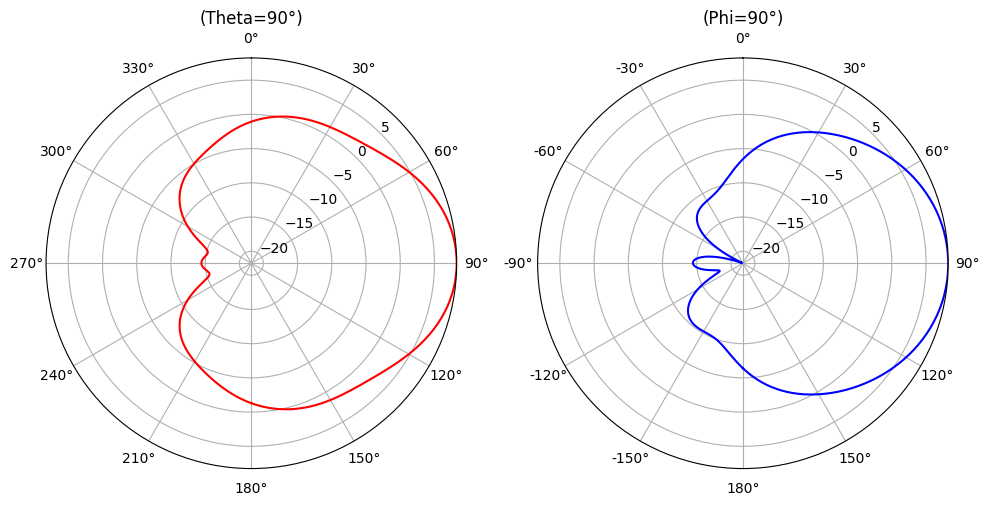

Gain max: 8.24878085228927


In [7]:
# Mode: TM10

dtr = np.pi/180
angulos = np.arange(-180,181,1) * dtr
angles = np.arange(0, 360, 30)
angles_labels = ['0°', '30°', '60°', '90°', '120°', '150°', '180°', '-150°', '-120°', '-90°', '-60°', '-30°']

fig, axs = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={'projection': 'polar'})

df_th = pd.read_csv('Gain Theta90 (dB).csv')
df_ph = pd.read_csv('Gain Phi90 (dB).csv')

gain_th = df_th['dB(GainTheta) []']
gain_ph = df_th['dB(GainPhi) []']

axs[0].plot(angulos, gain_th, 'r')
axs[0].plot(angulos, gain_ph, 'b')
axs[0].set_title('(Theta=90°)')
axs[0].set_theta_zero_location('N')
axs[0].set_theta_direction(-1)
axs[0].set_rlim(max(gain_th)-30, max(gain_th))
axs[0].set_thetagrids(angles)
axs[0].set_rlabel_position(45)


gain_ph = df_ph['dB(GainPhi) []']
gain_th = df_ph['dB(GainTheta) []']

axs[1].plot(angulos, gain_th, 'b')
axs[1].plot(angulos, gain_ph, 'r')
axs[1].set_title('(Phi=90°)')
axs[1].set_theta_zero_location('N')
axs[1].set_theta_direction(-1)
axs[1].set_rlim(max(gain_th)-30, max(gain_th))
axs[1].set_thetagrids(angles, labels=angles_labels)
axs[1].set_rlabel_position(45)

plt.tight_layout()
plt.savefig('Gain.png', dpi=300)
plt.show()

print("Gain max:", max(gain_th))

In [8]:
df_th = pd.read_csv('Gain Theta90 (dB).csv')
gain = df_th['dB(GainTheta) []'].to_numpy()
angles = df_th['Phi [deg]'].to_numpy()

max_gain = np.max(gain)
db3_level = max_gain - 3

indices = np.where(gain >= db3_level)[0]
phi_3db_left = angles[indices[0]]
phi_3db_right = angles[indices[-1]]
beamwidth = phi_3db_right - phi_3db_left

print(f'3 dB Angle for Theta = 90°: {beamwidth:.1f}° (from {phi_3db_left:.1f}° to {phi_3db_right:.1f}°)')

df_th = pd.read_csv('Gain Phi90 (dB).csv')
gain = df_th['dB(GainTheta) []'].to_numpy()
angles = df_th['Theta [deg]'].to_numpy()

max_gain = np.max(gain)
db3_level = max_gain - 3

indices = np.where(gain >= db3_level)[0]
phi_3db_left = angles[indices[0]]
phi_3db_right = angles[indices[-1]]
beamwidth = phi_3db_right - phi_3db_left

print(f'3 dB Angle for Phi = 90°: {beamwidth:.1f}° (from {phi_3db_left:.1f}° to {phi_3db_right:.1f}°)')

3 dB Angle for Theta = 90°: 55.0° (from 62.0° to 117.0°)
3 dB Angle for Phi = 90°: 65.0° (from 58.0° to 123.0°)


In [9]:
variations = hfss.available_variations.nominal_values
variations["Freq"] = ["1.57542GHz"]
variations["Theta"] = ["All"]
variations["Phi"] = ["All"]
gain_ffd_plot = hfss.post.create_report(expressions=["re(rEPhi)"],
                                             setup_sweep_name="GPS_Discrete",
                                             variations=variations,
                                             context="3D",                     # Far-field setup is pre-defined.
                                             report_category="Far Fields",
                                             plot_type="3D Polar Plot",
                                             plot_name="rE_Phi_re"
                                            )
hfss.post.export_report_to_csv(project_dir="C:/Users/ITA/Documents/Alunos/JoaoPedroFalcao/Mestrado/Codes/Arrays",plot_name="rE_Phi_re")

gain_ffd_plot = hfss.post.create_report(expressions=["im(rEPhi)"],
                                             setup_sweep_name="GPS_Discrete",
                                             variations=variations,
                                             context="3D",                     # Far-field setup is pre-defined.
                                             report_category="Far Fields",
                                             plot_type="3D Polar Plot",
                                             plot_name="rE_Phi_im"
                                            )
hfss.post.export_report_to_csv(project_dir="C:/Users/ITA/Documents/Alunos/JoaoPedroFalcao/Mestrado/Codes/Arrays",plot_name="rE_Phi_im")

gain_ffd_plot = hfss.post.create_report(expressions=["re(rETheta)"],
                                             setup_sweep_name="GPS_Discrete",
                                             variations=variations,
                                             context="3D",                     # Far-field setup is pre-defined.
                                             report_category="Far Fields",
                                             plot_type="3D Polar Plot",
                                             plot_name="rE_Theta_re"
                                            )
hfss.post.export_report_to_csv(project_dir="C:/Users/ITA/Documents/Alunos/JoaoPedroFalcao/Mestrado/Codes/Arrays",plot_name="rE_Theta_re")

gain_ffd_plot = hfss.post.create_report(expressions=["im(rETheta)"],
                                             setup_sweep_name="GPS_Discrete",
                                             variations=variations,
                                             context="3D",                     # Far-field setup is pre-defined.
                                             report_category="Far Fields",
                                             plot_type="3D Polar Plot",
                                             plot_name="rE_Theta_im"
                                            )
hfss.post.export_report_to_csv(project_dir="C:/Users/ITA/Documents/Alunos/JoaoPedroFalcao/Mestrado/Codes/Arrays",plot_name="rE_Theta_im")

'C:/Users/ITA/Documents/Alunos/JoaoPedroFalcao/Mestrado/Codes/Arrays\\rE_Theta_im.csv'

# Workbench

In [10]:
hfss.save_project()
hfss.release_desktop()

# Wait 2 seconds to allow AEDT to shut down before cleaning the temporary directory.
time.sleep(2)

temp_folder.cleanup()

PyAEDT INFO: Project Spherical_Array Saved correctly
PyAEDT INFO: Desktop has been released and closed.
